In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import pandas as pd


In [2]:
classes_description = ['normal driving',
'texting - right',
'talking on the phone - right',
'texting - left',
'talking on the phone - left',
'operating the radio',
'drinking',
'reaching behind',
'hair and makeup',
'talking to passenger']

In [3]:
PATH = "data/competitions/state-farm-distracted-driver-detection/"

sz=224
bs=24
arch=resnet50

In [4]:
ls {PATH}

driver_imgs_list.csv       tmp/
driver_imgs_list.csv.zip   train/
imgs.zip                   train_classes/
models/                    tta_sumbmission_98.csv
sample_submission.csv      tta_sumbmission_cleared.csv
sample_submission.csv.zip  tta_sumbmission.csv
test/


In [5]:
raw_label_csv = f'{PATH}driver_imgs_list.csv'
label_csv = 'f{PATH}train_driver.csv'

In [6]:
label_df = pd.read_csv(raw_label_csv)
n = len(label_df)

In [ ]:
print(n)
label_df.head()
label_df.to_csv(label_csv, columns=['img', 'classname'], index=False)

In [ ]:
val_idxs = get_cv_idxs(n)
np.save(f'{PATH}tmp/val_idxs', val_idxs)

In [7]:
val_idxs = np.load(f'{PATH}tmp/val_idxs.npy')

In [8]:
def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', label_csv, bs=bs,
                                       tfms=tfms, val_idxs=val_idxs, test_name='test')
    return data

In [9]:
data = get_data(sz, bs)

In [ ]:
files = os.listdir(f'{PATH}train')[:10000]

In [ ]:
r_files = np.random.choice(files, 5)
img = plt.imread(f'{PATH}train/{r_files[1]}')
plt.imshow(img);

In [ ]:
data.val_ds.fnames.shape

In [10]:
learn = ConvLearner.pretrained(arch, data, ps=0.5, precompute=False)

In [ ]:
learn.lr_find()

In [ ]:
learn.sched.plot()

In [ ]:
lr = 1e-3
learn.fit(lr, 3, cycle_len=1)

In [ ]:
learn.save('precomputed3')

In [ ]:
learn.load('precomputed3')

In [ ]:
learn.precompute=False
learn.fit(lr, 3, cycle_len=1)

In [ ]:
learn.save('augmented')

In [ ]:
learn.load('augmented')

In [ ]:
learn.unfreeze()
lrs = np.array([1e-5, 1e-4, 1e-3])
learn.lr_find(lrs/1000)

In [ ]:
learn.sched.plot()

In [ ]:
lrs = np.array([1e-6, 5e-5, 9e-4])
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

In [ ]:
learn.save('unfreeze_1')

In [ ]:
learn.load('unfreeze_1')

In [13]:
learn.unfreeze()
lrs = np.array([1e-6, 5e-5, 9e-4])
learn.fit(lrs, 1, cycle_len=4)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.123604   0.061799   0.985027  
    1      0.137046   0.053191   0.987656                     
    2      0.11079    0.051903   0.987923                     
    3      0.095132   0.050593   0.988815                     



[0.05059285, 0.9888146137171251]

In [14]:
learn.save('05-99-final')

In [11]:
learn.load('05-99-final')

In [12]:
learn.save('07-98-final')

In [12]:
learn.load('07-98-final')

In [ ]:
learn.set_data(data)

In [11]:
log_preds, y_preds = learn.TTA(is_test=True)

KeyboardInterrupt: 

In [12]:
val_log_preds, val_y = learn.TTA()

In [13]:
val_probs = np.mean(np.exp(val_log_preds), 0)
val_preds = np.argmax(val_probs, 1)

In [13]:
probs = np.mean(np.exp(log_preds), 0)
preds = np.argmax(probs, 1)

In [ ]:
answers = np.copy(probs)

In [ ]:
np.putmask(answers, answers<0.1, 0)

In [ ]:
answers.shape

In [ ]:
#filter_by_class = data.val_y==8
(val_preds == 8) & (data.val_y == 8) == True

In [18]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(class_idx, correct):
    #filter_by_class = data.val_y==class_idx
    return rand_by_mask((val_preds == class_idx) & (data.val_y == class_idx) == correct)
def rand_by_class(class_idx):
    #by_class = data.test_y == class_name
    return rand_by_mask(preds == class_idx)
def plot_test_with_title(idxs, class_idx, title, probs=val_probs):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    #title_probs = [probs[x] for x in idxs]
    title_probs = [f'{val_preds[x]} {probs[x][class_idx]}' for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [ ]:
np.argsort()

In [ ]:
def rand_by_most(class_idx):
    return 

In [16]:
def plots(ims, figsize=(16,8), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

Random correct by drinking


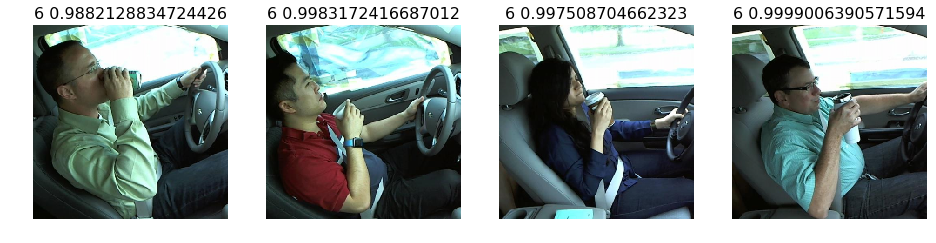

In [20]:
class_idx = 6
plot_test_with_title(rand_by_correct(class_idx, True), class_idx, 
                     f'Random correct by {classes_description[class_idx]}', val_probs)

In [ ]:
class_idx = 6
plot_test_with_title(rand_by_class(class_idx), class_idx, f"Random by {classes_description[class_idx]}")

In [17]:
def extract_img_name(fname): return re.search('test/(.*)', fname).group(1)
img_names = [extract_img_name(fname) for fname in data.test_ds.fnames]

In [ ]:
len(img_names)

In [ ]:
{data.classes[key]: probs[key] for key in range(0,10)}.keys()

In [18]:
df = pd.DataFrame({data.classes[key]: probs[:,key] for key in range(0,10)}, index=img_names)
#df['img'] = img_names
#df = pd.DataFrame(probs, index=img_names)
df.to_csv(f'{PATH}tta_sumbmission_98.csv',index_label='img')

In [19]:
lrs = np.array([1e-6, 5e-5, 9e-4])
learn.lr_find(lrs/1000)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 75%|███████▌  | 561/748 [01:10<00:23,  7.99it/s, loss=0.447]

In [22]:
learn.fit(lrs, 1, cycle_mult=5)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 12%|█▏        | 93/748 [00:09<01:07,  9.77it/s, loss=0.157]

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                    
    0      0.134023   0.066075   0.984581  



[0.0660749, 0.9845811013869423]